In [679]:
import numpy as np
import math
import random
from enum import Enum
import warnings
import time

In [637]:
uops = {np.sin, np.cos}
bops = {np.add, np.subtract, np.divide, np.multiply, np.power}

# configuration
MIN_OP_LEN = 1
MAX_OP_LEN = 10

MIN_INT_RANGE = -5
MAX_INT_RANGE = 5

is_operation_factor = 0.5


In [751]:
class NodeType(Enum):
    CONST = 1
    OP = 2
    VAR = 3
    EMPTY = 4


class OpType(Enum):
    U = "u"
    B = "b"


class Operator:
    str_mapper = {
        "sin": np.sin,
        "cos": np.cos,
        "add": np.add,
        "sub": np.subtract,
        "divide": np.divide,
        "multiply": np.multiply,
        "power": np.power
    }

    op_mapper = {
        np.sin.__name__: "sin",
        np.cos.__name__: "cos",
        np.add.__name__: "+",
        np.subtract.__name__: "-",
        np.divide.__name__: "/",
        np.multiply.__name__: "*",
        np.power.__name__: "^"
    }

    repr_to_func = {
        "sin": np.sin,
        "cos": np.cos,
        "+": np.add,
        "-": np.subtract,
        "*": np.multiply,
        "/": np.divide,
        "^": np.power,
    }
    
    def __init__(self, name):
        if type(name) == str:
            self.op = Operator.str_mapper.get(name, None)
            if self.op is not None:
                if self.op in uops:
                    self.type = OpType.U
                elif self.op in bops:
                    self.type = OpType.B
                else:
                    raise ValueError(f"{self.op} is in str_mapper but not in operation sets")
            else:
                raise ValueError(f"{name} is not a valid operator")

        elif name in uops:
            self.op = name
            self.type = OpType.U
            
        elif name in bops:
            self.op = name
            self.type = OpType.B
            
        else:
            raise ValueError(f"invalid name {name}")

    def copy(self):
        new_op = Operator(self.op)
        return new_op
    
    def __repr__(self):
        return f"Operator[op: {self.op}, type: {self.type}]"

    @staticmethod
    def generate_random_operator(pool: list = None):
        if pool is None:
            pool = pool = list(bops) * 2 + list(uops)
            
        return Operator(random.choice(pool))


class Node:
    
    #def __init__(self, depth=None, value=None, parent: "Node"=None, left: "Node"=None, right: "Node"=None, op=None):
        #self.depth: int = depth
    def __init__(self, value=None, parent: "Node"=None, left: "Node"=None, right: "Node"=None, op=None):
        self.type: NodeType = None
        self.value: int | str = value
        self.op: Operator = op
        self.parent: "Node" = parent
        self.right: "Node" = right
        self.left: "Node" = left
        self.fitness = 0
        self.mse = np.inf
        
    
    def evaluate(self, rng: np.array, real: np.array):
        assert len(rng) == len(real)
        
        np.seterr(over='raise')
        
        def calc_value(node, x):
            if node is None:
                return None
            if node.type == NodeType.CONST:
                return node.value
            if node.type == NodeType.VAR:
                return x
            if node.type == NodeType.EMPTY:
                return None
            if node.type == NodeType.OP:
                if node.op.type == OpType.U:
                    child = calc_value(node.left, x)
                    child = np.float64(child)
                    if child is not None:
                        with warnings.catch_warnings():
                            warnings.simplefilter("error", RuntimeWarning)

                            try:
                                value = node.op.op(child)
                            except RuntimeWarning as rw:
                                value = np.inf

                            return value
                    else:
                        raise Exception("wtf tree")

                elif node.op.type == OpType.B:
                    ch1 = calc_value(node.left, x)
                    ch2 = calc_value(node.right, x)
                    
                    if ch1 is not None and ch2 is not None:

                        with warnings.catch_warnings():
                            warnings.simplefilter("error", RuntimeWarning)
    
                            try:
                                value = node.op.op(ch1, ch2)
                            except RuntimeWarning as rw:
                                value = np.inf
                            except Exception:
                                value = np.inf
    
                        return value

                    else:
                        if ch1 is not None or ch2 is not None:
                            print(ch1, node.left)
                            print(ch2, node.right)
                            print(node)
                            raise Exception("wtf")
                            
                        return None
                else:
                    raise Exception("broken tree")

        predictions = np.array([calc_value(self, x) for x in rng], dtype=np.float64)
        real = np.array(real, dtype=np.float64)
        
        try:
            mse = np.mean(np.power(real - predictions, 2))
        except FloatingPointError:
            mse = np.inf
        finally:
            np.seterr(over='warn')

        self.mse = mse
        
        self.fitness = 10000 / mse if mse > 0 else np.inf

        return predictions
        

    @property
    def value(self):
        return self._value

    @value.setter
    def value(self, new_value):
        if new_value is None:
            self._value = None
            
        elif new_value == NodeType.EMPTY:
            self._value = None
            self.type = NodeType.EMPTY
            
        elif isinstance(new_value, int):
            self._value = new_value
            self.type = NodeType.CONST
        
        elif isinstance(new_value, str):
            self._value = new_value
            self.type = NodeType.VAR

        else:
            raise ValueError(f"invalid value {new_value}")

    def copy(self):
        new_node = Node()
        #new_node.depth = self.depth
        new_node.fitness = self.fitness
        new_node.mse = self.mse
        
        if self.type in [NodeType.CONST, NodeType.VAR]:
            new_node.value = self.value
        elif self.type == NodeType.OP:
            new_node.op = self.op.copy()
        elif self.type == NodeType.EMPTY:
            new_node.value = NodeType.EMPTY
        else:
            print(new_node)
            raise Exception("wtf error")
        
        return new_node

    def deepcopy(self):
        node = self.copy()

        if self.left is not None:
            node.left = self.left.deepcopy()
            node.left.parent = node
        if self.right is not None:
            node.right = self.right.deepcopy()
            node.right.parent = node

        return node
        
    @property
    def op(self):
        return self._op

    @op.setter
    def op(self, func):
        if func is None:
            self._op = None
            
        elif not isinstance(func, Operator):
            raise ValueError(f"{func} must be of type {Operator.__name__}")
            
        self._op = func    
        self.type = NodeType.OP

    @staticmethod
    def create_empty_node():
        node = Node()
        node.value = NodeType.EMPTY
        return node
    
    @staticmethod
    def create_random_node():
        return Node(op=random.choice(list(uops + bops)))
    
    def __repr__(self):
        if self.type is not None:
            if self.type == NodeType.OP:
                # return f"Node(type: {self.type}, op: {self.op}, depth: {self.depth})"
                return f"Node(type: {self.type}, op: {self.op})"
            else:
                # return f"Node(type: {self.type}, value: {self.value}, depth: {self.depth})"
                return f"Node(type: {self.type}, value: {self.value}"
        else:
            # return "Node(None, depth: inf)"
            return "Node(None)"
    

class Tree:

    def __init__(self, root=None):
        self.root = root

    def deepcopy(self) -> "Tree":
        root = self.root.deepcopy()
        new_tree = Tree(root)
        return new_tree
    
    def select_random_node(self):
        l = [self.root]
        nodes = []
        index = 0
        number_of_nodes = node_counter(self.root)
        
        while len(l):
            nd = l.pop()
            nodes.append(nd)
            num = random.random() * number_of_nodes
            if index + num / 10 >= num:
                selected_node = nd
                break
            
            index += 1
            
            if nd.left is not None and not nd.left.value == None:
                l.insert(0, nd.left)
            if nd.right is not None and not nd.right.value == None:
                l.insert(0, nd.right)
        else:
            selected_node = random.choice(nodes)

        return selected_node

    def healthy(self):
        l = [self.root]
        while len(l):
            nd = l.pop()
            if nd.type == NodeType.OP:
                if nd.op.type == OpType.B:
                    if nd.left is None or nd.left.value is None or nd.right is None or nd.right.value is None:
                        return False
                if nd.op.type == OpType.U:
                    if nd.left is None or nd.left.value is None: # none or empty
                        return False
            
            elif nd.type in [NodeType.CONST, NodeType.VAR]:
                if nd.value is None:
                    return False

            if nd.left is not None:
                l.insert(0, nd.left)
            if nd.right is not None:
                l.insert(0, nd.right)

        return True

    def _tree_structure(self, node):
        # DFS traversal
        repr_str = ""
        frontier = [node]
        while len(frontier):
            nd = frontier.pop()
            if nd is not None:
                if nd.type == NodeType.OP:
                    repr_str += f"Node(op={nd.op}\n"    
                else:
                    repr_str += f"Node(value={nd.value})\n"
                
                repr_str += f"L: {nd.left}\nR: {nd.right}\n---------------\n"

                frontier.append(nd.right)
                frontier.append(nd.left)

        return repr_str
        
    def __repr__(self):
        return f'Tree(root={self.root}, structure:\n{self._tree_structure(self.root)})'

    def __trace(self, node):
        if node is None:
            return ""
        if node.type == NodeType.CONST:
            return str(node.value)
        elif node.type == NodeType.OP:
            sign = Operator.op_mapper.get(node.op.op.__name__)

            if node.op.type == OpType.U:
                return f"{sign}({self.__trace(node.left)})"
            elif node.op.type == OpType.B:
                return f"({self.__trace(node.left)}{sign}{self.__trace(node.right)})"
        elif node.type == NodeType.VAR:
            return f"{node.value}"
            
        elif node.type == NodeType.EMPTY:
            return ""

    def __str__(self):
        return self.__trace(self.root)

    def __eq__(self, other):
        if not isinstance(other, Tree):
            return False
        return str(self) == str(other)

    def __hash__(self):
        number = ""
        for chr in str(self):
            number += str(ord(chr))

        return hash(number)


In [14]:
# def random_leaf(depth):
def random_leaf():
    if random.random() > 0.5:
        # new_node = Node(depth=depth)
        new_node = Node()
        new_node.value = random.randint(MIN_INT_RANGE, MAX_INT_RANGE)
    else:
        # new_node = Node(depth=depth)
        new_node = Node()
        new_node.value = "x"

    return new_node

In [32]:
# def create_random_tree(number_of_nodes: int = None, base_depth: int = 1):
def create_random_tree(number_of_nodes: int = None):
    
    if number_of_nodes is None:
        number_of_nodes = random.randint(MIN_OP_LEN, MAX_OP_LEN)
    if number_of_nodes < 1:
        # node = random_leaf(base_depth)
        node = random_leaf()
        return Tree(root=node)

    random_op = Operator.generate_random_operator()
    # root_node = Node(op=random_op, depth=base_depth)
    root_node = Node(op=random_op)
    tree = Tree(root_node)
    
    connected = []
    frontier = [tree.root]
    free = [Node() for _ in range(number_of_nodes - 1)]
    
    while len(free) > 0:
        random.shuffle(frontier)
        node = frontier.pop()
        if node.op.type == OpType.B:
            if random.random() > is_operation_factor and len(free) > 1:
                # both children are operators
                ch1 = free.pop()
                ch2 = free.pop()
                ch1.op = Operator.generate_random_operator()
                ch2.op = Operator.generate_random_operator()
                ch1.parent = node
                ch2.parent = node
                #ch1.depth = node.depth + 1
                #ch2.depth = node.depth + 1
                
                if random.random() > 0.5:
                    node.left = ch1
                    node.right = ch2
                else:
                    node.left = ch2
                    node.right = ch1
    
                connected.append(node)
                frontier.append(ch1)
                frontier.append(ch2)
                
            else:
                # only one child is operator
                ch = free.pop()
                ch.op = Operator.generate_random_operator()
                ch.parent = node
                #ch.depth = node.depth + 1
                
                if random.random() > 0.5:
                    node.right = ch
                else:
                    node.left = ch
    
                connected.append(node)
                frontier.append(ch)
        
        elif node.op.type == OpType.U:
            ch = free.pop()
            ch.op = Operator.generate_random_operator()
            ch.parent = node
            #ch.depth = node.depth + 1
            node.left = ch
            #empty_node = Node(depth=node.depth + 1)
            empty_node = Node()
            empty_node.value = NodeType.EMPTY
            empty_node.parent = node
            node.right = empty_node

            connected.append(node)
            frontier.append(ch)
    
    for node in frontier + connected:
        if node.left is None:
            # new_node = random_leaf(node.depth + 1)
            new_node = random_leaf()
            new_node.parent = node
            node.left = new_node

        if node.right is None:
            # new_node = random_leaf(node.depth + 1)
            new_node = random_leaf()
            new_node.parent = node
            node.right = new_node
    
    return tree

In [16]:
def node_counter(node: Node):
    # count number of nodes in the <node> 
    nc = 0
    l = [node]
    while len(l):
        nd = l.pop()
        nc += 1
        if nd.left is not None:
            l.append(nd.left)
        if nd.right is not None:
            l.append(nd.right)

    return nc

In [17]:
def update_depth(node: Node, new_depth: int):

    node.depth = new_depth
    
    l = []
    if node.left is not None:
        l.insert(0, node.left)
    if node.right is not None:
        l.insert(0, node.right)
        
    while len(l):
        nd = l.pop()
        nd.depth = nd.parent.depth + 1
        
        if nd.left is not None:
            l.insert(0, nd.left)
        if nd.right is not None:
            l.insert(0, nd.right)

In [18]:
def crossover(tree1: Tree, tree2: Tree):
    new_tree1 = tree1.deepcopy()
    new_tree2 = tree2.deepcopy()

    node1 = new_tree1.select_random_node()
    node2 = new_tree2.select_random_node()
        
    
    #update_depth(node1, node2.depth)
    #update_depth(node2, node1.depth)

    f1 = node1.parent
    f2 = node2.parent

    if f1 is not None and f2 is not None:
        if f1.left == node1:
            f1.left = node2
            node2.parent = f1
            
        elif f1.right == node1:
            f1.right = node2
            node2.parent = f1
    
        if f2.left == node2:
            f2.left = node1
            node1.parent = f2
            
        elif f2.right == node2:
            f2.right = node1
            node1.parent = f2
            
        return new_tree1, new_tree2
    else:
        return new_tree1, new_tree2
        if f1 is None and f2 is None:
            return new_tree1, new_tree2
        else:
            if f1 is None:
                node2.parent = None
                new_tree1.root = node2
                
                if f2.right == node2:
                    f2.right = node1
                    node1.parent = f2
                elif f2.left == node2:
                    f2.left = node1
                    node1.parent = f2    
            
            if f2 is None:
                node1.parent = None
                new_tree2.root = node1

                if f1.right == node1:
                    f1.right = node2
                    node2.parent = f1
                elif f1.left == node1:
                    f1.left = node2
                    node2.parent = f1    

    return new_tree1, new_tree2
                
        

In [19]:
def mutate(tree: Tree):
    selected_node = tree.select_random_node()
    if selected_node is None:
        raise Exception("selected_node is empty, what is the problem?")

    number_of_nodes = node_counter(selected_node)
    # sub_tree = create_random_tree(number_of_nodes = number_of_nodes // 2, base_depth = selected_node.depth)
    sub_tree = create_random_tree(number_of_nodes = number_of_nodes // 2)
    
    parent = selected_node.parent
    if parent is None:
        tree = sub_tree
        
    elif parent.left == selected_node:
        parent.left = sub_tree.root
        sub_tree.root.parent = parent
    elif parent.right == selected_node:
        parent.right = sub_tree.root
        sub_tree.root.parent = parent
    else:
        raise Exception("tree is broken")

In [20]:
import matplotlib.pyplot as plt

In [666]:
def has_none(tree: Tree):
    l = [tree.root]
    flag = False
    while len(l):
        nd = l.pop()
        
        if nd is None:
            if flag:
                return 2
            return 1
        if nd.right is None or nd.left is None:
            flag = True
        
        l.append(nd.right)
        l.append(nd.left)
    else:
        return 0


In [695]:
def genetic(
    X, Y, first_generation_len: int = 10, 
    max_generation_len: int = 20, timeout: int = 45, 
    mutation_factor: int = 0.1, min_op_len: int = 1,
    max_op_len: int = 10, min_int_range = -5,
    max_int_range: int = 5
):

    global MIN_INT_RANGE, MIN_OP_LEN, MAX_INT_RANGE, MAX_OP_LEN
    MIN_OP_LEN = min_op_len
    MAX_OP_LEN = max_op_len
    MIN_INT_RANGE = min_int_range
    MAX_INT_RANGE = max_int_range
    
    first_generation = []
    for i in range(first_generation_len):
        tree = create_random_tree()
        first_generation.append(tree)

    for t in first_generation:
        t.root.evaluate(X, Y)

    first_generation.sort(key=lambda tree: tree.root.fitness, reverse=True)

    max_len = max_generation_len
    rng = Y.max() - Y.min()
    
    start = time.perf_counter()
    
    while first_generation[0].root.mse / rng > 0.1:
        # iterate
        if time.perf_counter() - start > timeout:
            print("not found")
            break

        if random.random() < mutation_factor:
            # mutate
            number_of_mutation = random.randint(1, len(first_generation))
            
            for _ in range(number_of_mutation):
                tree = random.choice(first_generation)
                mutate(tree)
                if has_none(tree) != 2 or not tree.healthy:
                    print("bad operation in mutate")
    
        # crosover
        random.shuffle(first_generation)
        new_lst = first_generation.copy()
        
        for i in range(0, len(first_generation), 2):
            t1, t2 = crossover(first_generation[i], first_generation[i+1])
            if has_none(t1) != 2 or has_none(t2) != 2 or not t1.healthy or not t1.healthy:
                print("bad operation in crossover")

            new_lst.extend(crossover(first_generation[i], first_generation[i+1]))
    
        for trr in new_lst:
            trr.root.evaluate(X, Y)
        
        new_lst.sort(key=lambda tree: tree.root.fitness, reverse=True)
        
        first_generation = new_lst.copy()
    
        if len(first_generation) > max_len:
            first_generation = first_generation[:max_len]
    
        mx = first_generation[0].root.fitness
        mx = np.float64(mx)
        if np.isinf(mx):
            break
        
        num = int(random.random() * len(first_generation)) // 2
        if num < len(first_generation) // 4 and num != 0:
            first_generation = first_generation[:-num]
            for _ in range(num):
                new_tree = create_random_tree()
                first_generation.append(new_tree)

    return first_generation[0]
        

not found
Func: ((1+x)/(3*2))
fittness: 11695.544968116968
MSE: 0.8550264247848933


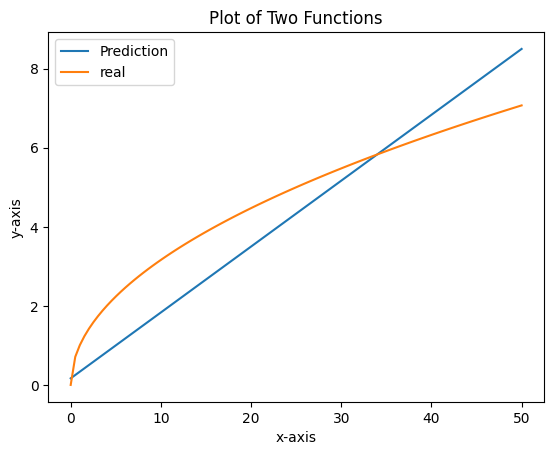

In [760]:
X = np.linspace(0, 50, 100)
Y = np.power(X, 0.5)

function = genetic(X, Y, min_op_len=1, max_op_len=3, min_int_range=1, max_int_range=4)

print(f"Func: {str(function)}")
print(f"fittness: {function.root.fitness}")
print(f"MSE: {function.root.mse}")

pred = function.root.evaluate(X, Y)

plt.plot(X, pred, label="Prediction")
plt.plot(X, Y, label="real")

plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Plot of Two Functions')
plt.legend()

plt.show()

not found
Func: (2^(sin(x)+((1/x)*(x+-2))))
fittness: 14354.433438145066
MSE: 0.6966488815522515


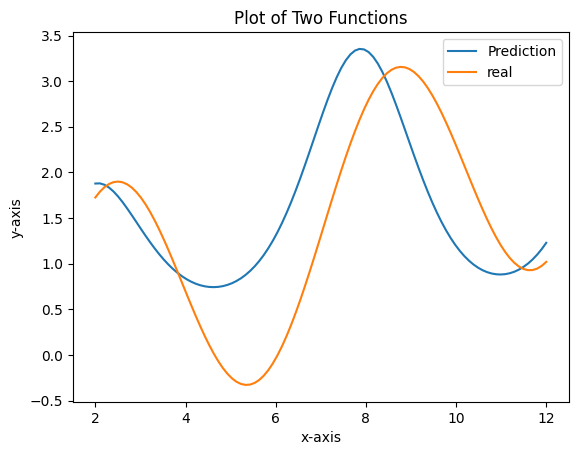

In [758]:
X = np.linspace(2, 12, 100)
Y = -np.cos(X) + np.sin(X) + X / 5
function = genetic(X, Y)

print(f"Func: {str(function)}")
print(f"fittness: {function.root.fitness}")
print(f"MSE: {function.root.mse}")

pred = function.root.evaluate(X, Y)

plt.plot(X, pred, label="Prediction")
plt.plot(X, Y, label="real")

plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Plot of Two Functions')
plt.legend()

plt.show()

not found
Func: (4-(cos(sin(3))/2))
fittness: 6675.645995588342
MSE: 1.4979823685391025


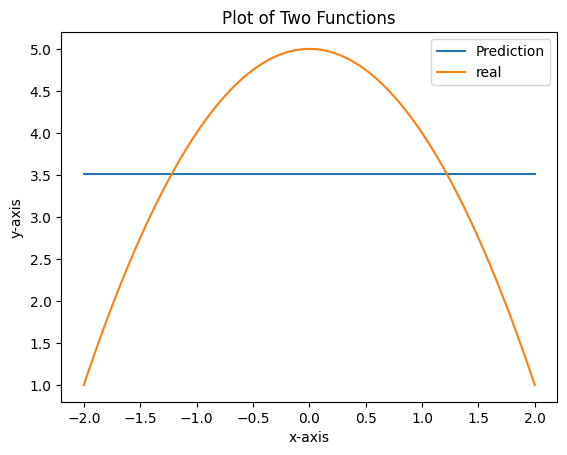

In [765]:
X = np.linspace(-2, 2, 100)
Y = 5-X**2

function = genetic(X, Y, timeout=30, min_op_len=2, max_op_len=5, min_int_range=1, max_int_range=10)

print(f"Func: {str(function)}")
print(f"fittness: {function.root.fitness}")
print(f"MSE: {function.root.mse}")

pred = function.root.evaluate(X, Y)

plt.plot(X, pred, label="Prediction")
plt.plot(X, Y, label="real")

plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Plot of Two Functions')
plt.legend()

plt.show()

Func: (2^x)
fittness: inf
MSE: 0.0


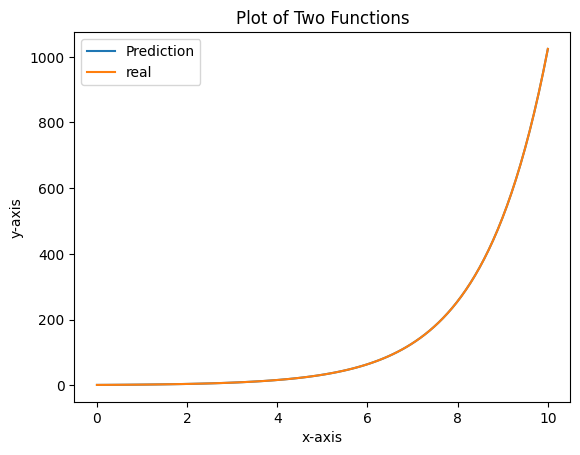

In [734]:
X = np.linspace(0, 10, 100)
Y = np.power(2, X)

function = genetic(X, Y, timeout=30, min_op_len=1, max_op_len=3, min_int_range=1, max_int_range=10)

print(f"Func: {str(function)}")
print(f"fittness: {function.root.fitness}")
print(f"MSE: {function.root.mse}")

pred = function.root.evaluate(X, Y)

plt.plot(X, pred, label="Prediction")
plt.plot(X, Y, label="real")

plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Plot of Two Functions')
plt.legend()

plt.show()

not found
Func: (6+cos(4))
fittness: 5603.924845995843
MSE: 1.7844636169853836


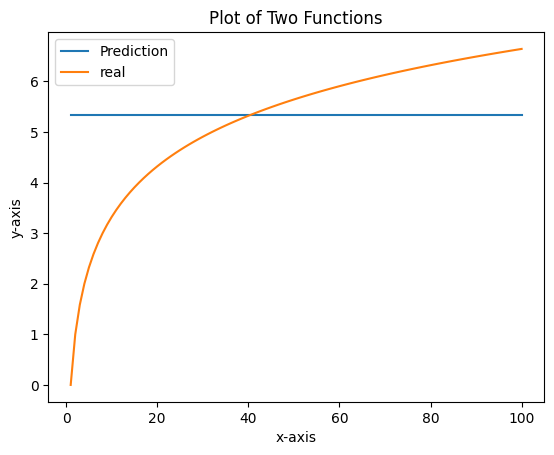

In [749]:
X = np.linspace(1, 100, 100)
Y = np.log2(X) # not in the functions pool

function = genetic(X, Y, timeout=45, min_op_len=2, max_op_len=5, min_int_range=1, max_int_range=10)

print(f"Func: {str(function)}")
print(f"fittness: {function.root.fitness}")
print(f"MSE: {function.root.mse}")

pred = function.root.evaluate(X, Y)

plt.plot(X, pred, label="Prediction")
plt.plot(X, Y, label="real")

plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Plot of Two Functions')
plt.legend()

plt.show()

not found
Func: sin((cos((sin((x+(x^3)))+(5/((x+3)^x))))+x))
fitness: 12707.201496098116
MSE: 0.786955334191451


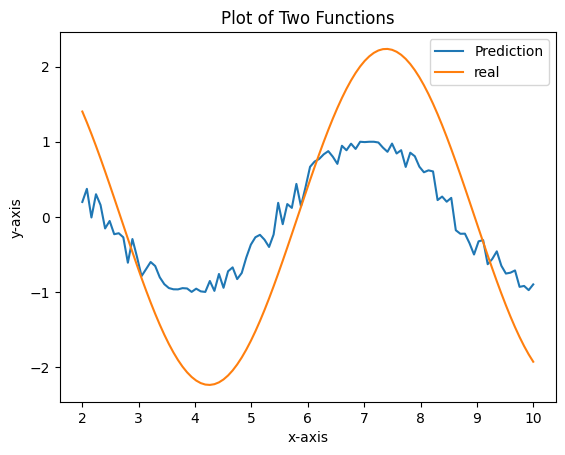

In [764]:
X = np.linspace(2, 10, 100)
Y = np.cos(X) + 2 * np.sin(X)
function = genetic(X, Y, min_op_len=3, max_op_len=10, min_int_range=1, max_int_range=5)

print(f"Func: {str(function)}")
print(f"fitness: {function.root.fitness}")
print(f"MSE: {function.root.mse}")

pred = function.root.evaluate(X, Y)

plt.plot(X, pred, label="Prediction")
plt.plot(X, Y, label="real")

plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Plot of Two Functions')
plt.legend()

plt.show()